In [1]:
# Библиотеки
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Чтоб числа вещественные выводились норм
pd.options.display.float_format ='{:,.2f}'.format

In [2]:
# sklearn.model_selection.GridSearchCV

**Загружаем данные**

In [3]:
df_2019_full = pd.read_csv('database/df_2019_full.csv')
df_2020_full = pd.read_csv('database/df_2020_full.csv')
df_2021_full = pd.read_csv('database/df_2021_full.csv')

df_2019_part = pd.read_csv('database/df_2019_part.csv')
df_2020_part = pd.read_csv('database/df_2020_part.csv')
df_2021_part = pd.read_csv('database/df_2021_part.csv')

In [4]:
target_2019_01_full = pd.read_csv('database/target_2019_01_full.csv')
target_2019_01_full = target_2019_01_full['target_2019 01']

target_2020_01_full = pd.read_csv('database/target_2020_01_full.csv')
target_2020_01_full = target_2020_01_full['target_2020 01']

target_2021_01_full = pd.read_csv('database/target_2021_01_full.csv')
target_2021_01_full = target_2021_01_full['target_2021 01']


target_2019_01_part = pd.read_csv('database/target_2019_01_part.csv')
target_2019_01_part = target_2019_01_part['target_2019 01']

target_2020_01_part = pd.read_csv('database/target_2020_01_part.csv')
target_2020_01_part = target_2020_01_part['target_2020 01']

target_2021_01_part = pd.read_csv('database/target_2021_01_part.csv')
target_2021_01_part = target_2021_01_part['target_2021 01']

**Считываем файлы со списками признаков**

Создадим словарь, в котором ключи имя файла, а значения:
- fs_zero - список признаков нулевой значимости, отобраный библеотекой Feature selector 
- fs_collinear - список признаков, отобранных для удаленния, имеющие высокую коореляцию
- остальные - списки признаков, ранжированные разными методами (важные - в начале) 


In [5]:
importances_feature = {}

for name_file in os.listdir('feature_list'):
    path_to_file = 'feature_list/'+name_file
    name_file = name_file.strip('.txt')
    file = open(path_to_file, 'r')
    importances_feature[name_file] = [line.strip() for line in file]
    file.close()
    
importances_feature.keys()

dict_keys(['fs_collinear', 'fs_zero', 'f_cl_importances', 'f_lr_importances', 'f_mi_importances', 'f_pi_f1_importances', 'f_pi_ra_importances', 'f_rfe_importances'])

**Тестирование разных моделей ML**

In [6]:
# Импортирование необходимых модулей и атрибутов
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score

In [7]:
import xgboost as xgb

Линейные алгоритмы:

    — Логистическая регрессия* / Logistic Regression (‘LR’)
    — Линейный дискриминантный анализ / Linear Discriminant Analysis (‘LDA’)

Нелинейные алгоритмы:

    — Метод k-ближайших соседей (классификация) / K-Neighbors Classifier (‘KNN’)
    — Деревья принятия решений / Decision Tree Classifier (‘CART’)
    — Наивный классификатор Байеса / Naive Bayes Classifier (‘NB’)
    — Линейный метод опорных векторов (классификация) / Linear Support Vector Classification (‘LSVC’)
    — Метод опорных векторов (классификация) / C-Support Vector Classification (‘SVC’)

Алгоритм искусственной нейронной сети:

    — Многослойный персептрон / Multilayer Perceptrons (‘MLP’)

Ансамблевые алгоритмы:

    — Bagging (классификация) / Bagging Classifier (‘BG’) (Bagging = Bootstrap aggregating)
    — Случайный лес (классификация) / Random Forest Classifier (‘RF’)
    — Экстра-деревья (классификация) / Extra Trees Classifier (‘ET’)
    — AdaBoost (классификация) / AdaBoost Classifier (‘AB’) (AdaBoost = Adaptive Boosting)
    — Градиентный boosting (классификация) / Gradient Boosting Classifier (‘GB’)

Таким образом, список ‘models’ содержит следующие модели:


In [8]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('LSVC', LinearSVC(random_state=42)))
models.append(('SVC', SVC(random_state=42)))
models.append(('MLP', MLPClassifier(random_state=42)))
models.append(('BG', BaggingClassifier(n_estimators=100, random_state=42)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('ET', ExtraTreesClassifier(n_estimators=100, random_state=42)))
models.append(('AB', AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42)))
models.append(('GB', GradientBoostingClassifier(n_estimators=100, random_state=42)))

In [9]:
def metrics(y_test, y_pred):
    """Комплексный расчет метрик"""
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred).round(4)
    recall = recall_score(y_test, y_pred).round(4)
    roc_auc = roc_auc_score(y_test, y_pred).round(4)
    f1 = f1_score(y_test, y_pred).round(4)
    
    # Если необходимо вывести метрики на печать - раскомментировать
    #print('Матрица:')
    #print(conf_matrix)
    #print('точность (precision) - ', precision)
    #print('полнота (recall) -', recall)
    #print('roc_auc - ', roc_auc)
    #print('f1_score - ', f1)
    
    return {'conf_matrix': conf_matrix, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc, 'f1': f1}

In [10]:
def ml_train(ml, X_train, X_test, y_train,  y_test):
    """Функция обучает переданную ей модель и считает метрики"""
    ml.fit(X_train, y_train)
    y_pred = ml.predict(X_test)
    return metrics(y_test, y_pred)
   

In [11]:
# Оценивание эффективности выполнения каждого алгоритма

def ml_tester(X_train, X_test, y_train, y_test, features, n_features):
    """Функция проводит обучение на разных моделях, и возвращает метрики
    feature - список признаков,
    n_feature - количество признаков, которые необходимо взять для обучения модели
    """
    
    X_train = X_train[importances_feature[features][:n_features]]
    X_test = X_test[importances_feature[features][:n_features]]
    
    metrixs_list = {}
    
    # Список моделей машинного обучения
    ml_LR = LogisticRegression( max_iter=2000, random_state=42)
    metrixs_list['ml_LR'] = ml_train(ml_LR, X_train, X_test, y_train, y_test)
    
    ml_LDA = LinearDiscriminantAnalysis()
    metrixs_list['ml_LDA'] = ml_train(ml_LDA, X_train, X_test, y_train, y_test)
    
    ml_KNN = KNeighborsClassifier()
    metrixs_list['ml_KNN'] = ml_train(ml_KNN, X_train, X_test, y_train, y_test)
    
    ml_CART = DecisionTreeClassifier(random_state=42)
    metrixs_list['ml_CART'] = ml_train(ml_CART, X_train, X_test, y_train, y_test)
    
    ml_NB = GaussianNB()
    metrixs_list['ml_NB'] = ml_train(ml_NB, X_train, X_test, y_train, y_test)
    
    ml_LSVC = LinearSVC(max_iter=100000, random_state=42)
    metrixs_list['ml_LSVC'] = ml_train(ml_LSVC, X_train, X_test, y_train, y_test)
    
    ml_SVC = SVC(random_state=42)
    metrixs_list['ml_SVC'] = ml_train(ml_SVC, X_train, X_test, y_train, y_test)
    
    ml_MLP = MLPClassifier(max_iter=2000, random_state=42)
    metrixs_list['ml_MLP'] = ml_train(ml_MLP, X_train, X_test, y_train, y_test)
    
    ml_BG = BaggingClassifier(n_estimators=100, random_state=42)
    metrixs_list['ml_BG'] = ml_train(ml_BG, X_train, X_test, y_train, y_test)
    
    ml_RF = RandomForestClassifier(n_estimators=100, random_state=42)
    metrixs_list['ml_RF'] = ml_train(ml_RF, X_train, X_test, y_train, y_test)
    
    ml_ET = ExtraTreesClassifier(n_estimators=100, random_state=42)
    metrixs_list['ml_ET'] = ml_train(ml_ET, X_train, X_test, y_train, y_test)
    
    ml_AB = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42)
    metrixs_list['ml_AB'] = ml_train(ml_AB, X_train, X_test, y_train, y_test)
    
    ml_GB = GradientBoostingClassifier(n_estimators=100, random_state=42)
    metrixs_list['ml_GB'] = ml_train(ml_GB, X_train, X_test, y_train, y_test)

    return metrixs_list


importances_feature keys:

    - 'f_cl_importances', 
    - 'f_lr_importances', 
    - 'f_mi_importances', 
    - 'f_pi_f1_importances', 
    - 'f_pi_ra_importances', 
    - 'f_rfe_importances'

In [12]:
metrixs_19_20_f_cl = ml_tester(df_2019_full, df_2020_full, target_2019_01_full, target_2020_01_full, 
                          'f_cl_importances', 50)
metrixs_20_21_f_cl = ml_tester(df_2020_full, df_2021_full, target_2020_01_full, target_2021_01_full, 
                          'f_cl_importances', 50)

print(target_2020_01_full.value_counts())

print('"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"')
print('Отбор признаков: "f_cl_importances" ')


df_metrixs_19_20_f_cl = pd.DataFrame(metrixs_19_20_f_cl).T

df_metrixs_20_21_f_cl = pd.DataFrame(metrixs_20_21_f_cl).T

df_f_cl = pd.concat([df_metrixs_19_20_f_cl, df_metrixs_20_21_f_cl], axis=1)
df_f_cl

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


1    247
0     78
Name: target_2020 01, dtype: int64
"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"
Отбор признаков: "f_cl_importances" 


,conf_matrix,precision,recall,roc_auc,f1,conf_matrix,precision,recall,roc_auc,f1
ml_LR,"[[25, 53], [50, 197]]",0.79,0.80,0.56,0.79,"[[7, 207], [16, 95]]",0.31,0.86,0.44,0.46
ml_LDA,"[[22, 56], [54, 193]]",0.78,0.78,0.53,0.78,"[[11, 203], [23, 88]]",0.30,0.79,0.42,0.44
ml_KNN,"[[31, 47], [79, 168]]",0.78,0.68,0.54,0.73,"[[20, 194], [17, 94]]",0.33,0.85,0.47,0.47
ml_CART,"[[41, 37], [94, 153]]",0.81,0.62,0.57,0.70,"[[53, 161], [33, 78]]",0.33,0.70,0.48,0.45
ml_NB,"[[14, 64], [32, 215]]",0.77,0.87,0.53,0.82,"[[207, 7], [105, 6]]",0.46,0.05,0.51,0.10
ml_LSVC,"[[25, 53], [52, 195]]",0.79,0.79,0.56,0.79,"[[11, 203], [21, 90]]",0.31,0.81,0.43,0.45
ml_SVC,"[[16, 62], [29, 218]]",0.78,0.88,0.54,0.83,"[[1, 213], [0, 111]]",0.34,1.00,0.50,0.51
ml_MLP,"[[35, 43], [88, 159]]",0.79,0.64,0.55,0.71,"[[29, 185], [21, 90]]",0.33,0.81,0.47,0.47
ml_BG,"[[32, 46], [69, 178]]",0.79,0.72,0.57,0.76,"[[17, 197], [20, 91]]",0.32,0.82,0.45,0.46
ml_RF,"[[32, 46], [62, 185]]",0.80,0.75,0.58,0.77,"[[10, 204], [16, 95]]",0.32,0.86,0.45,0.46


D:\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Метрики да базе c коэффиициентами 2019 - обучение, 2020 - тест'}>

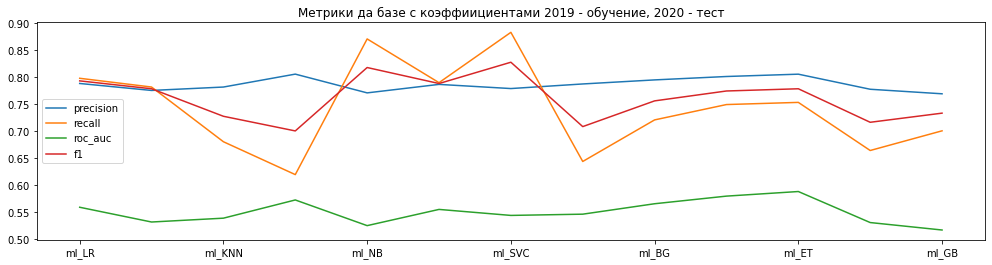

In [13]:
df_metrixs_19_20_f_cl.plot(title='Метрики да базе c коэффиициентами 2019 - обучение, 2020 - тест', figsize=(17, 4))

In [14]:
metrixs_19_20_f_lr = ml_tester(df_2019_full, df_2020_full, target_2019_01_full, target_2020_01_full, 
                          'f_lr_importances', 50)
metrixs_20_21_f_lr = ml_tester(df_2020_full, df_2021_full, target_2020_01_full, target_2021_01_full, 
                          'f_lr_importances', 50)

print(target_2020_01_full.value_counts())

print('"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"')
print('Отбор признаков: "f_lr_importances" ')

df_metrixs_19_20_f_lr = pd.DataFrame(metrixs_19_20_f_lr).T

df_metrixs_20_21_f_lr = pd.DataFrame(metrixs_20_21_f_lr).T

df_f_lr = pd.concat([df_metrixs_19_20_f_lr, df_metrixs_20_21_f_lr], axis=1)
df_f_lr

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


1    247
0     78
Name: target_2020 01, dtype: int64
"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"
Отбор признаков: "f_lr_importances" 


,conf_matrix,precision,recall,roc_auc,f1,conf_matrix,precision,recall,roc_auc,f1
ml_LR,"[[28, 50], [67, 180]]",0.78,0.73,0.54,0.75,"[[17, 197], [21, 90]]",0.31,0.81,0.45,0.45
ml_LDA,"[[32, 46], [67, 180]]",0.80,0.73,0.57,0.76,"[[17, 197], [24, 87]]",0.31,0.78,0.43,0.44
ml_KNN,"[[29, 49], [63, 184]]",0.79,0.74,0.56,0.77,"[[10, 204], [15, 96]]",0.32,0.86,0.46,0.47
ml_CART,"[[38, 40], [108, 139]]",0.78,0.56,0.53,0.65,"[[44, 170], [30, 81]]",0.32,0.73,0.47,0.45
ml_NB,"[[14, 64], [38, 209]]",0.77,0.85,0.51,0.80,"[[27, 187], [44, 67]]",0.26,0.60,0.36,0.37
ml_LSVC,"[[31, 47], [69, 178]]",0.79,0.72,0.56,0.75,"[[9, 205], [19, 92]]",0.31,0.83,0.44,0.45
ml_SVC,"[[9, 69], [22, 225]]",0.77,0.91,0.51,0.83,"[[1, 213], [7, 104]]",0.33,0.94,0.47,0.49
ml_MLP,"[[37, 41], [82, 165]]",0.80,0.67,0.57,0.73,"[[39, 175], [21, 90]]",0.34,0.81,0.50,0.48
ml_BG,"[[31, 47], [62, 185]]",0.80,0.75,0.57,0.77,"[[17, 197], [20, 91]]",0.32,0.82,0.45,0.46
ml_RF,"[[30, 48], [58, 189]]",0.80,0.77,0.57,0.78,"[[5, 209], [19, 92]]",0.31,0.83,0.43,0.45


In [15]:
metrixs_19_20_f_mi = ml_tester(df_2019_full, df_2020_full, target_2019_01_full, target_2020_01_full, 
                          'f_mi_importances', 50)
metrixs_20_21_f_mi = ml_tester(df_2020_full, df_2021_full, target_2020_01_full, target_2021_01_full, 
                          'f_mi_importances', 50)

print(target_2020_01_full.value_counts())

print('"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"')
print('Отбор признаков: "f_mi_importances" ')

df_metrixs_19_20_f_mi = pd.DataFrame(metrixs_19_20_f_mi).T

df_metrixs_20_21_f_mi = pd.DataFrame(metrixs_20_21_f_mi).T

df_f_mi = pd.concat([df_metrixs_19_20_f_mi, df_metrixs_20_21_f_mi], axis=1)
df_f_mi

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


1    247
0     78
Name: target_2020 01, dtype: int64
"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"
Отбор признаков: "f_mi_importances" 


,conf_matrix,precision,recall,roc_auc,f1,conf_matrix,precision,recall,roc_auc,f1
ml_LR,"[[25, 53], [45, 202]]",0.79,0.82,0.57,0.80,"[[8, 206], [17, 94]]",0.31,0.85,0.44,0.46
ml_LDA,"[[28, 50], [52, 195]]",0.80,0.79,0.57,0.79,"[[11, 203], [25, 86]]",0.30,0.77,0.41,0.43
ml_KNN,"[[22, 56], [77, 170]]",0.75,0.69,0.49,0.72,"[[12, 202], [15, 96]]",0.32,0.86,0.46,0.47
ml_CART,"[[42, 36], [100, 147]]",0.80,0.60,0.57,0.68,"[[46, 168], [26, 85]]",0.34,0.77,0.49,0.47
ml_NB,"[[63, 15], [219, 28]]",0.65,0.11,0.46,0.19,"[[6, 208], [22, 89]]",0.30,0.80,0.41,0.44
ml_LSVC,"[[27, 51], [49, 198]]",0.80,0.80,0.57,0.80,"[[14, 200], [23, 88]]",0.31,0.79,0.43,0.44
ml_SVC,"[[1, 77], [2, 245]]",0.76,0.99,0.50,0.86,"[[1, 213], [6, 105]]",0.33,0.95,0.48,0.49
ml_MLP,"[[28, 50], [74, 173]]",0.78,0.70,0.53,0.74,"[[39, 175], [22, 89]]",0.34,0.80,0.49,0.47
ml_BG,"[[34, 44], [62, 185]]",0.81,0.75,0.59,0.78,"[[13, 201], [20, 91]]",0.31,0.82,0.44,0.45
ml_RF,"[[24, 54], [50, 197]]",0.78,0.80,0.55,0.79,"[[8, 206], [19, 92]]",0.31,0.83,0.43,0.45


In [16]:
metrixs_19_20_f_pi_f1 = ml_tester(df_2019_full, df_2020_full, target_2019_01_full, target_2020_01_full, 
                          'f_pi_f1_importances', 50)
metrixs_20_21_f_pi_f1 = ml_tester(df_2020_full, df_2021_full, target_2020_01_full, target_2021_01_full, 
                          'f_pi_f1_importances', 50)

print(target_2020_01_full.value_counts())

print('"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"')
print('Отбор признаков: "f_pi_f1_importances" ')


df_metrixs_19_20_f_pi_f1 = pd.DataFrame(metrixs_19_20_f_pi_f1).T

df_metrixs_20_21_f_pi_f1 = pd.DataFrame(metrixs_20_21_f_pi_f1).T

df_f_pi_f1 = pd.concat([df_metrixs_19_20_f_pi_f1, df_metrixs_20_21_f_pi_f1], axis=1)
df_f_pi_f1

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


1    247
0     78
Name: target_2020 01, dtype: int64
"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"
Отбор признаков: "f_pi_f1_importances" 


,conf_matrix,precision,recall,roc_auc,f1,conf_matrix,precision,recall,roc_auc,f1
ml_LR,"[[26, 52], [63, 184]]",0.78,0.74,0.54,0.76,"[[8, 206], [15, 96]]",0.32,0.86,0.45,0.46
ml_LDA,"[[28, 50], [66, 181]]",0.78,0.73,0.55,0.76,"[[11, 203], [20, 91]]",0.31,0.82,0.44,0.45
ml_KNN,"[[29, 49], [65, 182]]",0.79,0.74,0.55,0.76,"[[14, 200], [12, 99]]",0.33,0.89,0.48,0.48
ml_CART,"[[36, 42], [104, 143]]",0.77,0.58,0.52,0.66,"[[43, 171], [25, 86]]",0.33,0.77,0.49,0.47
ml_NB,"[[25, 53], [50, 197]]",0.79,0.80,0.56,0.79,"[[10, 204], [24, 87]]",0.30,0.78,0.42,0.43
ml_LSVC,"[[26, 52], [74, 173]]",0.77,0.70,0.52,0.73,"[[6, 208], [17, 94]]",0.31,0.85,0.44,0.46
ml_SVC,"[[4, 74], [2, 245]]",0.77,0.99,0.52,0.87,"[[1, 213], [6, 105]]",0.33,0.95,0.48,0.49
ml_MLP,"[[33, 45], [87, 160]]",0.78,0.65,0.54,0.71,"[[35, 179], [20, 91]]",0.34,0.82,0.49,0.48
ml_BG,"[[31, 47], [73, 174]]",0.79,0.70,0.55,0.74,"[[11, 203], [18, 93]]",0.31,0.84,0.44,0.46
ml_RF,"[[25, 53], [55, 192]]",0.78,0.78,0.55,0.78,"[[8, 206], [15, 96]]",0.32,0.86,0.45,0.46


In [17]:
metrixs_19_20_f_pi_ra = ml_tester(df_2019_full, df_2020_full, target_2019_01_full, target_2020_01_full, 
                          'f_pi_ra_importances', 50)
metrixs_20_21_f_pi_ra = ml_tester(df_2020_full, df_2021_full, target_2020_01_full, target_2021_01_full, 
                          'f_pi_ra_importances', 50)

print(target_2020_01_full.value_counts())

print('"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"')
print('Отбор признаков: "f_pi_ra_importances" ')

df_metrixs_19_20_f_pi_ra = pd.DataFrame(metrixs_19_20_f_pi_ra).T

df_metrixs_20_21_f_pi_ra = pd.DataFrame(metrixs_20_21_f_pi_ra).T

df_f_pi_ra = pd.concat([df_metrixs_19_20_f_pi_ra, df_metrixs_20_21_f_pi_ra], axis=1)
df_f_pi_ra

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


1    247
0     78
Name: target_2020 01, dtype: int64
"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"
Отбор признаков: "f_pi_ra_importances" 


,conf_matrix,precision,recall,roc_auc,f1,conf_matrix,precision,recall,roc_auc,f1
ml_LR,"[[21, 57], [59, 188]]",0.77,0.76,0.52,0.76,"[[11, 203], [13, 98]]",0.33,0.88,0.47,0.48
ml_LDA,"[[22, 56], [54, 193]]",0.78,0.78,0.53,0.78,"[[14, 200], [19, 92]]",0.32,0.83,0.45,0.46
ml_KNN,"[[38, 40], [69, 178]]",0.82,0.72,0.60,0.77,"[[12, 202], [12, 99]]",0.33,0.89,0.47,0.48
ml_CART,"[[33, 45], [96, 151]]",0.77,0.61,0.52,0.68,"[[46, 168], [29, 82]]",0.33,0.74,0.48,0.45
ml_NB,"[[20, 58], [49, 198]]",0.77,0.80,0.53,0.79,"[[9, 205], [33, 78]]",0.28,0.70,0.37,0.40
ml_LSVC,"[[21, 57], [65, 182]]",0.76,0.74,0.50,0.75,"[[15, 199], [14, 97]]",0.33,0.87,0.47,0.48
ml_SVC,"[[3, 75], [1, 246]]",0.77,1.00,0.52,0.87,"[[1, 213], [6, 105]]",0.33,0.95,0.48,0.49
ml_MLP,"[[32, 46], [67, 180]]",0.80,0.73,0.57,0.76,"[[31, 183], [18, 93]]",0.34,0.84,0.49,0.48
ml_BG,"[[32, 46], [73, 174]]",0.79,0.70,0.56,0.75,"[[15, 199], [18, 93]]",0.32,0.84,0.45,0.46
ml_RF,"[[27, 51], [61, 186]]",0.78,0.75,0.55,0.77,"[[8, 206], [19, 92]]",0.31,0.83,0.43,0.45


In [18]:
metrixs_19_20_f_rfe = ml_tester(df_2019_full, df_2020_full, target_2019_01_full, target_2020_01_full, 
                          'f_rfe_importances', 50)
metrixs_20_21_f_rfe = ml_tester(df_2020_full, df_2021_full, target_2020_01_full, target_2021_01_full, 
                          'f_rfe_importances', 50)

print(target_2020_01_full.value_counts())

print('"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"')
print('Отбор признаков: "f_rfe_importances" ')

df_metrixs_19_20_f_rfe = pd.DataFrame(metrixs_19_20_f_rfe).T

df_metrixs_20_21_f_rfe= pd.DataFrame(metrixs_20_21_f_rfe).T

df_f_rfe = pd.concat([df_metrixs_19_20_f_rfe, df_metrixs_20_21_f_rfe], axis=1)
df_f_rfe

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


1    247
0     78
Name: target_2020 01, dtype: int64
"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"
Отбор признаков: "f_rfe_importances" 


,conf_matrix,precision,recall,roc_auc,f1,conf_matrix,precision,recall,roc_auc,f1
ml_LR,"[[20, 58], [49, 198]]",0.77,0.80,0.53,0.79,"[[13, 201], [16, 95]]",0.32,0.86,0.46,0.47
ml_LDA,"[[27, 51], [61, 186]]",0.78,0.75,0.55,0.77,"[[16, 198], [21, 90]]",0.31,0.81,0.44,0.45
ml_KNN,"[[29, 49], [69, 178]]",0.78,0.72,0.55,0.75,"[[23, 191], [18, 93]]",0.33,0.84,0.47,0.47
ml_CART,"[[31, 47], [109, 138]]",0.75,0.56,0.48,0.64,"[[47, 167], [35, 76]]",0.31,0.68,0.45,0.43
ml_NB,"[[23, 55], [49, 198]]",0.78,0.80,0.55,0.79,"[[9, 205], [32, 79]]",0.28,0.71,0.38,0.40
ml_LSVC,"[[23, 55], [55, 192]]",0.78,0.78,0.54,0.78,"[[12, 202], [17, 94]]",0.32,0.85,0.45,0.46
ml_SVC,"[[1, 77], [0, 247]]",0.76,1.00,0.51,0.87,"[[1, 213], [4, 107]]",0.33,0.96,0.48,0.50
ml_MLP,"[[38, 40], [88, 159]]",0.80,0.64,0.57,0.71,"[[29, 185], [21, 90]]",0.33,0.81,0.47,0.47
ml_BG,"[[26, 52], [75, 172]]",0.77,0.70,0.51,0.73,"[[17, 197], [19, 92]]",0.32,0.83,0.45,0.46
ml_RF,"[[30, 48], [61, 186]]",0.79,0.75,0.57,0.77,"[[17, 197], [17, 94]]",0.32,0.85,0.46,0.47


Проверим метрики на стандартизированных признаках

In [21]:
def ml_ss_tester(X_train, X_test, y_train, y_test, features, n_features):
    """Функция проводит обучение на разных моделях, и возвращает метрики
    feature - список признаков,
    n_feature - количество признаков, которые необходимо взять для обучения модели
    """
    
    X_train = X_train[importances_feature[features][:n_features]]
    X_test = X_test[importances_feature[features][:n_features]]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    metrixs_list = {}
    
    # Список моделей машинного обучения
    ml_LR = LogisticRegression( max_iter=2000, random_state=42)
    metrixs_list['ml_LR'] = ml_train(ml_LR, X_train, X_test, y_train, y_test)
    
    ml_LDA = LinearDiscriminantAnalysis()
    metrixs_list['ml_LDA'] = ml_train(ml_LDA, X_train, X_test, y_train, y_test)
    
    ml_KNN = KNeighborsClassifier()
    metrixs_list['ml_KNN'] = ml_train(ml_KNN, X_train, X_test, y_train, y_test)
    
    ml_CART = DecisionTreeClassifier(random_state=42)
    metrixs_list['ml_CART'] = ml_train(ml_CART, X_train, X_test, y_train, y_test)
    
    ml_NB = GaussianNB()
    metrixs_list['ml_NB'] = ml_train(ml_NB, X_train, X_test, y_train, y_test)
    
    ml_LSVC = LinearSVC(max_iter=100000, random_state=42)
    metrixs_list['ml_LSVC'] = ml_train(ml_LSVC, X_train, X_test, y_train, y_test)
    
    ml_SVC = SVC(random_state=42)
    metrixs_list['ml_SVC'] = ml_train(ml_SVC, X_train, X_test, y_train, y_test)
    
    ml_MLP = MLPClassifier(max_iter=2000, random_state=42)
    metrixs_list['ml_MLP'] = ml_train(ml_MLP, X_train, X_test, y_train, y_test)
    
    ml_BG = BaggingClassifier(n_estimators=100, random_state=42)
    metrixs_list['ml_BG'] = ml_train(ml_BG, X_train, X_test, y_train, y_test)
    
    ml_RF = RandomForestClassifier(n_estimators=100, random_state=42)
    metrixs_list['ml_RF'] = ml_train(ml_RF, X_train, X_test, y_train, y_test)
    
    ml_ET = ExtraTreesClassifier(n_estimators=100, random_state=42)
    metrixs_list['ml_ET'] = ml_train(ml_ET, X_train, X_test, y_train, y_test)
    
    ml_AB = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42)
    metrixs_list['ml_AB'] = ml_train(ml_AB, X_train, X_test, y_train, y_test)
    
    ml_GB = GradientBoostingClassifier(n_estimators=100, random_state=42)
    metrixs_list['ml_GB'] = ml_train(ml_GB, X_train, X_test, y_train, y_test)

    return metrixs_list

In [22]:
metrixs_19_20_f_cl = ml_ss_tester(df_2019_full, df_2020_full, target_2019_01_full, target_2020_01_full, 
                          'f_cl_importances', 50)
metrixs_20_21_f_cl = ml_ss_tester(df_2020_full, df_2021_full, target_2020_01_full, target_2021_01_full, 
                          'f_cl_importances', 50)

print(target_2020_01_full.value_counts())

print('"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"')
print('Отбор признаков: "f_cl_importances" ')


df_metrixs_19_20_f_cl = pd.DataFrame(metrixs_19_20_f_cl).T

df_metrixs_20_21_f_cl = pd.DataFrame(metrixs_20_21_f_cl).T

df_f_cl = pd.concat([df_metrixs_19_20_f_cl, df_metrixs_20_21_f_cl], axis=1)
df_f_cl

1    247
0     78
Name: target_2020 01, dtype: int64
"обучение на 2019, прогноз на 2020" и "обучение на 2020, прогноз на 2021"
Отбор признаков: "f_cl_importances" 


,conf_matrix,precision,recall,roc_auc,f1,conf_matrix,precision,recall,roc_auc,f1
ml_LR,"[[24, 54], [59, 188]]",0.78,0.76,0.53,0.77,"[[12, 202], [19, 92]]",0.31,0.83,0.44,0.45
ml_LDA,"[[22, 56], [54, 193]]",0.78,0.78,0.53,0.78,"[[11, 203], [23, 88]]",0.30,0.79,0.42,0.44
ml_KNN,"[[31, 47], [74, 173]]",0.79,0.70,0.55,0.74,"[[11, 203], [8, 103]]",0.34,0.93,0.49,0.49
ml_CART,"[[41, 37], [94, 153]]",0.81,0.62,0.57,0.70,"[[55, 159], [33, 78]]",0.33,0.70,0.48,0.45
ml_NB,"[[10, 68], [24, 223]]",0.77,0.90,0.52,0.83,"[[209, 5], [107, 4]]",0.44,0.04,0.51,0.07
ml_LSVC,"[[24, 54], [60, 187]]",0.78,0.76,0.53,0.77,"[[11, 203], [20, 91]]",0.31,0.82,0.44,0.45
ml_SVC,"[[23, 55], [40, 207]]",0.79,0.84,0.57,0.81,"[[1, 213], [2, 109]]",0.34,0.98,0.49,0.50
ml_MLP,"[[34, 44], [86, 161]]",0.79,0.65,0.54,0.71,"[[35, 179], [18, 93]]",0.34,0.84,0.50,0.49
ml_BG,"[[31, 47], [67, 180]]",0.79,0.73,0.56,0.76,"[[17, 197], [20, 91]]",0.32,0.82,0.45,0.46
ml_RF,"[[34, 44], [61, 186]]",0.81,0.75,0.59,0.78,"[[10, 204], [16, 95]]",0.32,0.86,0.45,0.46
